## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [2]:
pip install odc-geo --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Load packages

In [4]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr
from odc.algo import mask_cleanup

from dea_tools.dask import create_local_dask_cluster
from intertidal.extents import load_data, pixel_tide_sort, item, nidem, parallel_apply, pixel_tides, ds_to_flat, create_dask_gateway_cluster, abslmp_correction

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Connect to datacube
dc = datacube.Datacube(app='Intertidal_elevation')

Client Scheduler: tcp://127.0.0.1:43725 Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


## Setup

In [ ]:
# aoi = 'McCarthur River'
aoi = 'Greenbank'
# aoi = 'Seven Emu'
# aoi = 'Wollogorang'

# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

In [6]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Load data

In [7]:
client

Client Scheduler: tcp://127.0.0.1:43725 Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


In [9]:
ds = load_data(dc=dc, 
               geom=geom, 
               time_range=('2012', '2022'), 
               resolution=30, 
               s2_prod=None,  #"s2_nbart_ndwi",
               ls_prod="ls_nbart_ndwi")[['ndwi']]
ds

<xarray.Dataset>
Dimensions:      (time: 395, y: 164, x: 191)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-16T00:47:06.964591 ... 2022-07...
  * y            (y) float64 8.229e+06 8.229e+06 ... 8.224e+06 8.224e+06
  * x            (x) float64 7.398e+05 7.398e+05 ... 7.455e+05 7.455e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [10]:
# Load into memory
ds.load()

<xarray.Dataset>
Dimensions:      (time: 395, y: 164, x: 191)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-16T00:47:06.964591 ... 2022-07...
  * y            (y) float64 8.229e+06 8.229e+06 ... 8.224e+06 8.224e+06
  * x            (x) float64 7.398e+05 7.398e+05 ... 7.455e+05 7.455e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 0.4439 0.4356 0.47 ... 0.7884 0.7863
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

## Pixel-based tides

In [11]:
# Model tides into every pixel in the dataset, and set tide pixels to nodata
# TODO: Work out why this works if `_reproject` is defined here, but fails if
# `_reproject` is defined in script
def _reproject(x, to_geobox=ds.odc.geobox):
    return x.odc.reproject(to_geobox, resampling="cubic")

ds["tide_m"], _ = pixel_tides(ds, resample_func=_reproject, directory='~/tide_models_clipped')

# Set tide pixels to nodata
ds["tide_m"] = ds["tide_m"].where(~ds.to_array().isel(variable=0).isnull())

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 395/395 [00:00<00:00, 791.41it/s]


In [ ]:
# # Optionally apply ABSMLP tide correction
# ds = abslmp_correction(ds)

## ITEM/NIDEM method

In [ ]:
# intervals=10

# # Add tide height dimension
# ds_item = ds.copy()
# ds_item['tide_height'] = ds_item.tide_m.mean(dim=['x', 'y'])
# ds_item = ds_item.swap_dims({"time": "tide_height"}).drop("time")

In [ ]:
# # Calculate intertidal extents
# ds_item.persist()
# item_da, ds_intervals, ds_confidence = item(ds_item, tide_dim='tide_height', intervals=intervals)
# item_da.plot.imshow(cmap='RdYlBu_r', size=6)

In [ ]:
# # Convert ITEM to NIDEM elevations
# intertidal_dem_clean = nidem(item_da, ds_intervals, intervals)
# intertidal_dem_clean.plot.imshow(cmap='viridis', size=6)

In [ ]:
# # fname = 'testing'
# fname = aoi.lower().replace(" ", "")

# # Export as a GeoTIFF
# intertidal_dem_clean.odc.write_cog(
#     fname=f"data/interim/nidem_dem_{fname}.tif", overwrite=True
# )
# ds_confidence.ndwi.odc.write_cog(
#     fname=f"data/interim/nidem_confidence_{fname}.tif", overwrite=True
# )

## Pixel-based

### Flatten array

In [13]:
# Flatten array to only pixels with positive correlations between water 
# observations and tide height. This greatly improves processing time by 
# ensuring only a narrow strip of pixels along the coastline are analysed,
# rather than the entire x * y array
ds_flat, freq, good_mask = ds_to_flat(
    ds, ndwi_thresh=0.0, min_freq=0.01, max_freq=0.99, min_correlation=0.25
)  # .sel(time=slice('2019', '2019'))

Reducing analysed pixels from 31324 to 2907 (9.28%)


### Test pixel-wise rolling median

In [14]:
# Calculate tide min, max, range
tide_max = ds_flat.tide_m.max(dim='time')
tide_min = ds_flat.tide_m.min(dim='time')
tide_range = tide_max - tide_min

# Choose number of rolling window intervals and window radius
window_interval_n = 100  # number of window intervals to iterate over
window_tide_prop = 0.15  #  0.15  # proportion of the tide range to use as window radius
window_tide = tide_range * window_tide_prop  # window radius in tide/metre units
window_interval_tide = tide_range / window_interval_n  # interval size in time/metre units
window_interval_buffer = int((window_interval_n * window_tide_prop) / 2.0)


In [15]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from odc.algo import xr_quantile

# # Experiment with removing bottom right quadrant
# mean_tide = ds_flat.tide_m.mean(dim='time')
# mean_ndwi = ds_flat.ndwi.mean(dim='time')
# lr = ((ds_flat.ndwi < mean_ndwi) & (ds_flat.tide_m > mean_tide))

# # Experiment with boolean/dry wet array
# ds_bool = ds_flat.copy()
# ds_bool['ndwi'] = (ds_flat.ndwi > 0.0).where(~ds_flat.ndwi.isnull())


def rolling_tide_window(
    i,
    ds=ds_flat,
    interval_tide=window_interval_tide,
    interval_window=window_tide,
    statistic='median',
#     lr=lr
):

    # Set min and max thresholds to filter dataset
    thresh_centre = tide_min + (i * interval_tide)
    thresh_min = thresh_centre - interval_window
    thresh_max = thresh_centre + interval_window

    # Filter dataset
    masked_ds = ds.where((ds.tide_m >= thresh_min) & (ds.tide_m <= thresh_max))  # & ~lr)

    # Apply median or quantile
    if statistic == 'quantile':
        ds_agg = xr_quantile(src=masked_ds, quantiles=[0.1, 0.5, 0.9], nodata=np.nan)
    elif statistic == 'median':
        ds_agg = masked_ds.median(dim="time").expand_dims(quantile=[0.5])
    elif statistic == 'mean':
        ds_agg = masked_ds.mean(dim="time").expand_dims(quantile=[0.5])

    # Add standard deviation
    ds_agg["ndwi_std"] = masked_ds.ndwi.std(dim="time")
    ds_agg["ndwi_count"] = (~masked_ds.ndwi.isnull()).sum(dim="time")

    return ds_agg


with ProcessPoolExecutor(max_workers=64) as executor:

    # Apply func in parallel
    rolling_intervals = range(
        -window_interval_buffer, window_interval_n + window_interval_buffer
    )
    out_list = list(
        tqdm(
            executor.map(rolling_tide_window, rolling_intervals),
            total=len(list(rolling_intervals)),
        )
    )

# Combine to match the original dataset
interval_ds = xr.concat(out_list, dim="interval").sortby(["interval", "x", "y"])

100%|██████████| 114/114 [00:00<00:00, 414.17it/s]


In [16]:
# Output name
fname = "testing"
ndwi_thresh = 0.1
# fname = aoi.lower().replace(' ', '')

# Calculate confidence (mean of NDWI standard deviation)
confidence = interval_ds.ndwi_std.mean(dim="interval").unstack("z").reindex_like(ds).T

# Export DEM for each quantile
for q in interval_ds["quantile"].data:

    # Extract relevant quantile data
    print(f"Processing quantile {q}")
    quantile_ds = interval_ds.sel(quantile=q).copy()

    # Smooth
    quantile_ds = quantile_ds.rolling(interval=20, center=False, min_periods=1).mean()

    # Identify the max tide per pixel where NDWI == land
    tide_dry = quantile_ds.tide_m.where(
        quantile_ds.ndwi <= ndwi_thresh
    )
    tide_thresh = tide_dry.max(dim="interval")
    tide_max = quantile_ds.tide_m.max(dim="interval")

    # Remove any pixel where tides max out (i.e. always land), and unstack back
    # to 3D array
    always_dry = tide_thresh >= tide_max
    dem = tide_thresh.where(~always_dry)
    dem = dem.unstack("z").reindex_like(ds).transpose('y', 'x')

    # Export DEM file
    suffix = {0.1: "dem_high", 0.5: "dem", 0.9: "dem_low"}[q]
    dem.odc.write_cog(
        fname=f"data/interim/pixel_{fname}_{suffix}.tif", overwrite=True
    )

# Export NDWI standard deviation/confidence file
confidence.odc.write_cog(
    fname=f"data/interim/pixel_{fname}_confidence.tif", overwrite=True
)

Processing quantile 0.5


PosixPath('data/interim/pixel_testing_confidence.tif')

## Experimental: Create extents layer

In [ ]:
# Calculate percent of astronomical tide range for each intertidal pixel
astro_tides, _ = pixel_tides(
    ds,
    times=pd.date_range(start="2000", end="2021", freq="5H"),
    calculate_quantiles=[0.0, 1.0],
    resample_func=_reproject,
    directory='~/tide_models_clipped'
)
astro_tide_min, astro_tide_max = astro_tides.groupby("quantile")
astro_tide_min, astro_tide_max = astro_tide_min[1], astro_tide_max[1]
tide_perc_da = ((dem - astro_tide_min) * 100) / (astro_tide_max - astro_tide_min)

# Identify pixels that were always wet or always dry across rolling medians
nontidal_dry_da = always_dry.unstack("z").reindex_like(ds).transpose('y', 'x') == True
nontidal_wet_da = tide_thresh.isnull().unstack("z").reindex_like(ds).transpose('y', 'x') == True

# Create integer array with 0 = always observed as land, 100 = always observed
# as water, and remaining values the % of the astronomical tide range represented
# by each pixel of intertidal terrain
extents_da = (
    odc.geo.xr.xr_zeros(ds.odc.geobox)  # create empty array
    .where(freq > 0.5, 100)  # Set mostly dry pixels to 100, and leave mostly wet as 0
    .where(~nontidal_dry_da, 100)  # Set any non-tidal dry pixels to 100
    .where(~nontidal_wet_da, 0)  # Set any non-tidal wet pixels to 0
    .where(tide_perc_da.isnull(), tide_perc_da.clip(0, 100))  # Fill intertidal with %s
).astype(np.uint16)

# Ensure CRS is present
# extents_da = extents_da.odc.assign_crs(ds.odc.geobox.crs)

extents_da.odc.write_cog(
    fname=f"data/interim/pixel_{fname}_extents.tif", overwrite=True
)

In [ ]:
# Clean data using morphological opening to remove narrow inland 
# streams and waterbodies
clean=[("opening", 20), ("dilation", 10)]
to_keep = mask_cleanup(extents_da < 100, mask_filters=clean)
dem_clean = dem.where(to_keep)

# Export to file
dem_clean.odc.write_cog(
        fname=f"data/interim/pixel_{fname}_{suffix}_cleaned.tif", overwrite=True
    )

In [ ]:
test = ds.tide_m.mean(dim=['x', 'y'])

## Experimental: Remove water not attached to ocean

In [ ]:
from skimage.measure import label, regionprops

In [ ]:
# First, break boolean array into unique, discrete regions/blobs
blobs = xr.apply_ufunc(label, to_keep, 0, False, 1)

# Get blob ID for each blob inside ocean area
ocean = dc.load(product="geodata_coast_100k", like=ds.odc.geobox.compat).land == 0
ocean_blobs = np.unique(blobs.where(ocean, 0))

# Return only blobs that contained tide modelling point
ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

In [ ]:
ocean_mask.plot()

In [ ]:
# First, break boolean array into unique, discrete regions/blobs
blobs = xr.apply_ufunc(label, ds, 1, False, 1)

# Get blob ID for each tidal modelling point
x = xr.DataArray(tide_points_gdf.geometry.x, dims="z")
y = xr.DataArray(tide_points_gdf.geometry.y, dims="z")
ocean_blobs = np.unique(blobs.interp(x=x, y=y, method="nearest"))

# Return only blobs that contained tide modelling point
ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

# Dilate mask so that we include land pixels on the inland side
# of each shoreline to ensure contour extraction accurately
# seperates land and water spectra
if dilation:
    ocean_mask = xr.apply_ufunc(binary_dilation, ocean_mask, disk(dilation))

return ocean_mask

## Regression experiment

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
ds_subset = interval_ds.where((interval_ds.ndwi > 0.05) & (interval_ds.ndwi < 0.25))
linreg = lag_linregress_3D(x=ds_subset.tide_m, y=ds_subset.ndwi, first_dim='interval')

In [ ]:
# linreg.intercept.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
# linreg.slope.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
testing = ((0 - linreg.intercept) / linreg.slope).where(linreg.pval < 0.01).unstack("z").reindex_like(ds)  #.plot.imshow(vmin=-1, vmax=0.5)

In [ ]:
testing = testing.where(testing > ds_subset.tide_m.min())

In [ ]:
testing.T.odc.write_cog(fname=f'data/interim/pixel_linreg7.tif', overwrite=True)

In [ ]:
y = mx + a
(y - a) / m

In [ ]:
ds.geobox

In [ ]:
quantile_ds.tide_m.where(quantile_ds.ndwi <= 0.1).dropna(dim='z', how='all')

In [ ]:
(tide_argmax + 1).unstack("z").reindex_like(ds).T.plot()

In [ ]:
tide_dry.isel(interval=(tide_argmax - 1).clip(0, len(tide_dry.interval) - 1))

In [ ]:
tide_dry.isel(tide_argmax)

In [ ]:
tide_argmax + 1

In [ ]:
tide_dry.dropna(dim='interval', how='all').argmax(dim='interval', axis=1)

In [ ]:
interval_ds

In [ ]:
# # Output name
# fname = 'testing1'
# # fname = aoi.lower().replace(' ', '')

# # Calculate 
# confidence = interval_ds.ndwi_std.mean(dim='interval')
# min_thresh = (0 - 0.5 * confidence)
# max_thresh = (0 + 0.5 * confidence)

# for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
#     dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
#     print(f'Exporting {dem_fname}')
    
#     # Identify the max tide per pixel where NDWI == land
#     tide_thresh = interval_ds.tide_m.where(interval_ds.ndwi <= thesh).max(dim='interval')
#     tide_max = interval_ds.tide_m.max(dim='interval')
    
#     # Remove any pixel where tides max out (i.e. always land)
#     dem = tide_thresh.where(tide_thresh < tide_max)
    
#     # Export DEM file  
# #     dem.T.odc.write_cog(fname=dem_fname, overwrite=True)
#     dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).T.odc.write_cog(fname=dem_fname, overwrite=True)
    

# # Export NDWI standard deviation/confidence file
# confidence.T.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

In [ ]:
# dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).plot()

In [ ]:
# dem.where(~(tide_thresh.isnull() & (freq > 0.90)), dem.min()).plot()

In [ ]:
interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest')

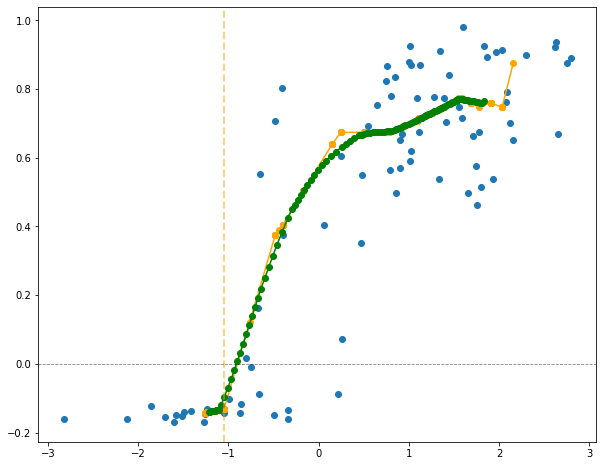

In [37]:
x, y = -1156521.12372093, 7712141.96160016
ndwi_thresh = 0.0

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sortby(["interval", "x", "y"]).sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)


# clipped = pixel_rolling.where((pixel_rolling.ndwi > 0) & (pixel_rolling.ndwi < 0.1)).dropna()

# ax.plot(clipped.tide_m, clipped.ndwi, '-o', color='green')
# from scipy import stats
# linreg = stats.linregress(x=clipped.tide_m, y=clipped.ndwi)
# x = np.linspace(pixel_raw.tide_m.min(), pixel_raw.tide_m.max())
# # ax.plot(x, [linreg.slope * i + linreg.intercept for i in x], color='green', linestyle='--')
# tide_thresh_3 = (ndwi_thresh - linreg.intercept) / linreg.slope

# rolling2 = pixel_raw.sort_values('tide_m').rolling(100, center=True, min_periods=1).median()
# ax.plot(rolling2.tide_m, rolling2.ndwi, '-o', color='red')



# tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
# tide_thresh_2 = pixel_rolling.tide_m.iloc[max_ind + 1]

# ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
# ax.axvline(tide_thresh_2, color='red', linestyle='--', lw=0.8, alpha=0.5)
# ax.axvline(tide_thresh_3, color='green', linestyle='--', lw=2, alpha=0.5)
# ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
x, y = 801144.14604825, 8189103.58475355
ndwi_thresh = 0.1

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
(pixel_rolling.ndwi * (10* pixel_rolling.ndwi.abs())).plot()

In [ ]:
ds_sub = ds.sel(x=x,  y=y, method='nearest')


ds_sub.sel(time=(ds_sub.ndwi < 0) & (ds_sub.tide_m > 0.25)).time

In [ ]:
from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_rolling.ndwi.values, 50, 2) # window size 51, polynomial order 3
plt.plot(yhat)

In [ ]:
test = np.array([-0.5, -0.2, -0.01, 0, 0.01, 0.2, 0.5])

In [ ]:
import scipy.stats
plt.plot(scipy.stats.norm.pdf(test, loc=0, scale=1))

In [ ]:
from skimage import exposure

In [ ]:
plt.plot(test)

In [ ]:
plt.plot(exposure.adjust_gamma(np.abs(test), 2))

In [ ]:



from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_raw.ndwi.values, 25, 3) # window size 51, polynomial order 3

pixel_rolling.ndwi.plot()
plt.plot(yhat)

In [ ]:
pixel_raw.ndwi.plot()

In [ ]:
interval_ds.ndwi2

In [ ]:
clipped_test = pixel_rolling.where((pixel_rolling.ndwi > -0.1) & (pixel_rolling.ndwi < 0.1)).dropna().rolling(5, center=True).mean()
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

diff = clipped_test.ndwi.diff() / clipped_test.ndwi.index.to_series().diff()
plt.plot(clipped_test.tide_m, diff, '-o', color='red')

plt.axvline(clipped_test.tide_m.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.axhline(clipped_test.ndwi.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)

In [ ]:
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

In [ ]:
pdf = gaussian_kde(pixel_rolling.ndwi.values, bw_method=0.5, weights=scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))
x = np.linspace(-0.5, 0.5, 200)
y = pdf(x)
plt.axvline(x[y.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.plot(x, y, label='kde')

In [ ]:
from scipy.stats import gaussian_kde


In [ ]:
import scipy.stats
plt.scatter(pixel_rolling.ndwi.values, scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))

In [ ]:
pixel_raw.tide_m.min()

In [ ]:
pixel_raw.ndwi.plot.density(bw_method=0.05)

In [ ]:
pixel_rolling.ndwi.plot()
(pixel_rolling.ndwi.diff() / pixel_rolling.ndwi.index.to_series().diff()).plot()

In [ ]:
from scipy.signal import savgol_filter
w = savgol_filter(y.sort_values('ndwi').ndwi, 5, 2)
w

In [ ]:
y.sort_values('tide_m').ndwi

In [ ]:
# tide_thresh_2 = 


In [ ]:
pixel_rolling.where(pixel_rolling.ndwi < 0).tide_m.argmax()

In [ ]:
x, y = 642456.7107189415, 8275569.497920433
pixel = interval_ds.sel(x=x,  y=y, method='nearest')
df_median = pixel.to_dataframe().reset_index()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_m, y=df_median.ndwi)
tide_thresh_1 = df_median.where(df_median.ndwi < 0).tide_m.max()
tide_thresh_2 = df_median.where(df_median.ndwi > 0).tide_m.min()
ax.axvline((tide_thresh_1 + tide_thresh_2) / 2)
ax.axhline(0)

### Elevation calculation

In [ ]:
# Output name
fname = 'testing1'
# fname = aoi.lower().replace(' ', '')

# Calculate 
min_thresh = (0 - 0.5 * s2_stdev_mean)
max_thresh = (0 + 0.5 * s2_stdev_mean)

for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
    dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
    print(f'Exporting {dem_fname}')
    
    # Identify the max tide per pixel where NDWI == land
    tide_thresh = ds.tide_m.where(s2_median <= thesh).max(dim='tide_n')
    tide_max = ds.tide_m.max(dim='tide_n')
    
    # Remove any pixel where tides max out (i.e. always land)
    dem = tide_thresh.where(tide_thresh < tide_max)
    
    # Export DEM file  
    dem.odc.write_cog(fname=dem_fname, overwrite=True)

# Export NDWI standard deviation/confidence file
s2_stdev_mean.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

### Experimental

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
# reg = lag_linregress_3D(s2_rolling.tide_height, (s2_rolling > 0).where(~s2_rolling.isnull()), first_dim='tide_height')
# (reg.pval < 0.01).plot.imshow()

In [ ]:
# s2_rolling

In [ ]:
# test_min = tide_3d.where(s2_rolling >= 0).min(dim='tide_height')
# test_max = tide_3d.where(s2_rolling < 0).max(dim='tide_height')
# # dem = test_min.where(~test_max.isnull())
# dem = ((test_max + test_min) / 2.0)
# write_cog(dem, fname='pixel_dem_mccarthurriver.tif', overwrite=True)


In [ ]:
# out = xr.corr(s2_rolling, tide_3d)

In [ ]:
write_cog(test_max, fname='pixel_dem13.tif', overwrite=True)  # 

In [ ]:
x, y = 755234.5430086093, 8215882.783825266
# pixel = s2_rolling.sel(x=x,  y=y, method='nearest')
# df_median = pixel.to_dataframe()[['ndwi']].reset_index()

pixel = ds.sel(x=x,  y=y, method='nearest')
df = pixel.to_dataframe()[['ndwi']].reset_index()
df_median = df.rolling(100, min_periods=10, center=True).median()
df_std = df.rolling(100, min_periods=10, center=True).std()
std_mean = df_std.ndwi.mean()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_height, y=df_median.ndwi)
# ax.axvline(df_median.where(df_median.ndwi > 0).tide_height.min())
ax.axvline(df_median.where(df_median.ndwi < 0).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 + std_mean * 0.5)).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 - std_mean * 0.5)).tide_height.max())
ax.axhline(0)

In [ ]:
std_mean.ndwi

In [ ]:
df_median.where(df_median.ndwi < 0).tide_height.max()

In [ ]:
df_median.where(df_median.ndwi > 0).tide_height.min()

# Shut down cluster

In [ ]:
from dask_gateway import Gateway
gateway = Gateway()

# Close any existing clusters
cluster_names = gateway.list_clusters()
if len(cluster_names) > 0:
    print("Cluster(s) still running:", cluster_names)
    for n in cluster_names:
        cluster = gateway.connect(n.name)
        cluster.shutdown()

In [ ]:
cluster.shutdown()